In [26]:
from pandas import read_csv
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [4]:
deaths = read_csv('overdose_deaths.csv')
calls = read_csv('overdose_calls.csv')
medication_treatment = read_csv('treatment.csv')

In [246]:
buprenorphine = medication_treatment[medication_treatment['metric'] == 'Buprenorphine'].sort_values(by='year')
methadone = medication_treatment[medication_treatment['metric'] == 'Methadone'].sort_values(by='year')
discharges = medication_treatment[medication_treatment['metric'] == 'WM Discharges'].sort_values(by='reporting_period_start_date')
admissions = medication_treatment[medication_treatment['metric'] == 'SUD Residential Treatment Admissions'].sort_values(by='reporting_period_start_date')
naloxone = medication_treatment[medication_treatment['metric'] == 'Naloxone'].sort_values(by='reporting_period_start_date')

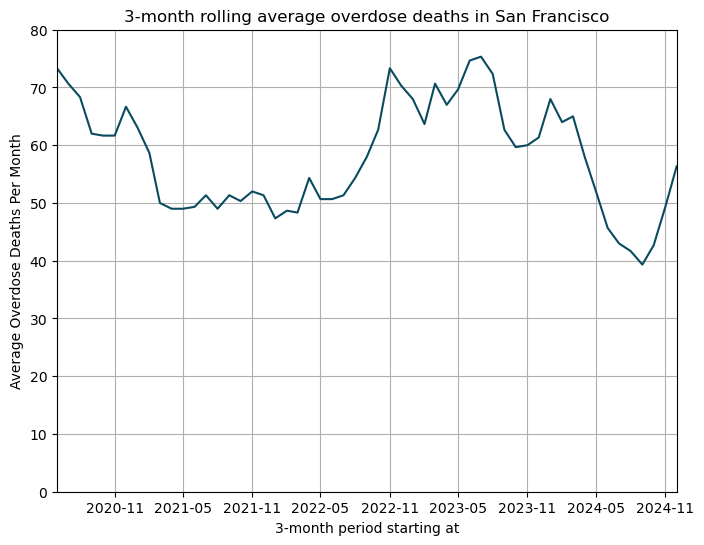

In [364]:
smoothed_deaths = []
months = 3
start_date = datetime(2020,6,1)
end_date = datetime(2025,3,2)
offset_months = 0
while start_date + relativedelta(months=offset_months + months) <= end_date:
    check_date = start_date + relativedelta(months=offset_months)
    agg = 0
    for k in [check_date + relativedelta(months=l) for l in range(months)]:
        od = deaths[deaths['month_start_date'] == k.strftime('%Y/%m/%d')]
        agg += int(od.iloc[0]['total_deaths'])
    smoothed_deaths.append({'date': check_date, 'avg_deaths': agg / months})
    offset_months += 1

fig, ax = plt.subplots(figsize=(8, 6))

locator = mdates.MonthLocator(interval=6)
year_month_formatter = mdates.DateFormatter("%Y-%m")

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_ylim(0, 80)
ax.set_xlim(start_date, end_date-relativedelta(months=months))
ax.set_title(f'{months}-month rolling average overdose deaths in San Francisco')
ax.set_ylabel('Average Overdose Deaths Per Month')
ax.set_xlabel(f'{months}-month period starting at')

ax.plot([i['date'] for i in smoothed_deaths],[i['avg_deaths'] for i in smoothed_deaths], color='#0A4A5F')
plt.savefig('deaths.png')

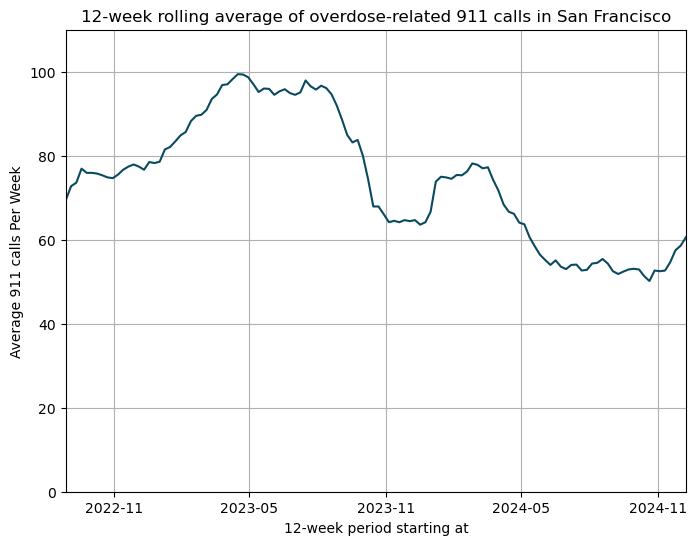

In [362]:
smoothed_calls = []
week_window = 12
start_date = datetime(2022,8,28)
end_date = datetime(2025,3,2)
offset_weeks = 0
while start_date + relativedelta(weeks=offset_weeks + week_window) <= end_date:
    agg = 0
    view_date = start_date + relativedelta(weeks=offset_weeks)
    for k in [view_date + relativedelta(weeks=l) for l in range(week_window)]:
        week = calls[calls['week_start_date'] == k.strftime('%Y/%m/%d')]
        agg += int(week.iloc[0]['total_overdose_related_911_calls'])
    smoothed_calls.append({'date': view_date, 'avg_calls': agg / week_window})
    offset_weeks += 1

fig, ax = plt.subplots(figsize=(8, 6))

locator = mdates.MonthLocator(interval=6)
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_ylim(0, 110)
ax.set_xlim(start_date, end_date-relativedelta(weeks=week_window))
ax.set_title(f'{week_window}-week rolling average of overdose-related 911 calls in San Francisco')
ax.set_ylabel('Average 911 calls Per Week')
ax.set_xlabel(f'{week_window}-week period starting at')

ax.plot([i['date'] for i in smoothed_calls],[i['avg_calls'] for i in smoothed_calls], color='#0A4A5F')
plt.savefig('calls.png')

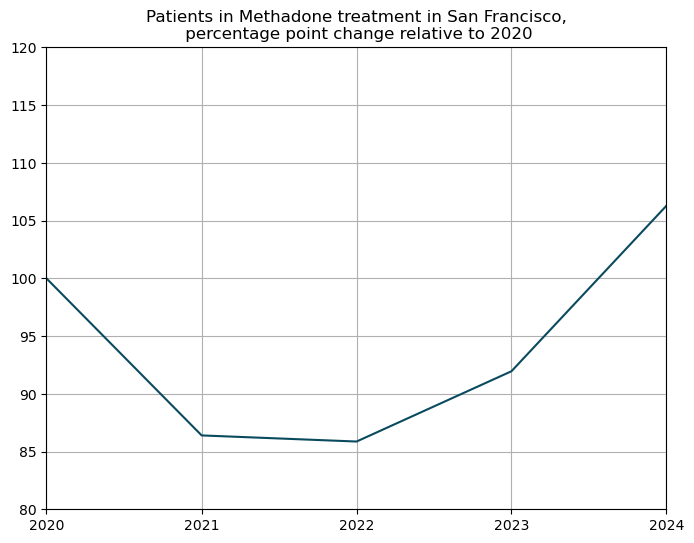

In [358]:
m_baseline = methadone[methadone['reporting_period_start_date'] == '2020/01/01'].iloc[0]
m_baseline_count = int(m_baseline['metric_value'])
methadone_change = [{'start_date': datetime(2020,1,1), 'pct_change': 100}]
for _, row in methadone.iterrows():
    if row['reporting_period_start_date'] != '2020/01/01' and row['reporting_period_type'] == 'Annual (Full)':
        m_treatment_counts = int(row['metric_value'])
        m_pct_change = 100 * (m_treatment_counts  / m_baseline_count)
        m_date = datetime.strptime(row['reporting_period_start_date'], '%Y/%m/%d')

        methadone_change.append({'start_date': m_date, 'pct_change': m_pct_change})

fig, ax = plt.subplots(figsize=(8, 6))

locator = mdates.MonthLocator(interval=12)
year_month_formatter = mdates.DateFormatter("%Y") # four digits for year, two for month

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(year_month_formatter)

ax.set_ylim(80, 120)
ax.set_xlim(datetime(2020,1,1), datetime(2024,1,1))

ax.grid()

ax.set_title(f'Patients in Methadone treatment in San Francisco,\n percentage point change relative to 2020')

ax.plot([i['start_date'] for i in methadone_change], [i['pct_change'] for i in methadone_change], color='#0A4A5F')
plt.savefig('methadone.png')

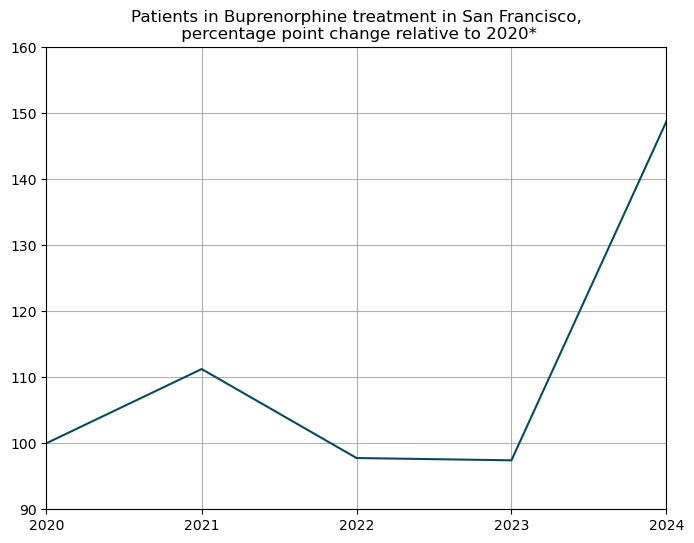

In [356]:
b_baseline = buprenorphine[buprenorphine['reporting_period_start_date'] == '2020/01/01'].iloc[0]
b_baseline_count = int(b_baseline['metric_value'])
buprenorphine_change = [{'start_date': datetime(2020,1,1), 'pct_change': 100}]
for _, row in buprenorphine.iterrows():
    if row['reporting_period_start_date'] != '2020/01/01':
        b_treatment_counts = int(row['metric_value'])
        
        # 2024 only goes up to September, so regularize it
        b_pct_change =  100 * ((b_treatment_counts * (12/9 if row['reporting_period_type'] == 'Annual (Partial)' else 1))/ b_baseline_count)
        b_date = datetime.strptime(row['reporting_period_start_date'], '%Y/%m/%d')
        buprenorphine_change.append({'start_date': b_date, 'pct_change': b_pct_change})

fig, ax = plt.subplots(figsize=(8, 6))

locator = mdates.MonthLocator(interval=12)
year_month_formatter = mdates.DateFormatter("%Y")

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(year_month_formatter)

ax.set_ylim(90, 160)
ax.set_xlim(datetime(2020,1,1), datetime(2024,1,1))

ax.grid()

ax.set_title(f'Patients in Buprenorphine treatment in San Francisco,\n percentage point change relative to 2020*')

ax.plot([i['start_date'] for i in buprenorphine_change], [i['pct_change'] for i in buprenorphine_change], color='#0A4A5F')
plt.savefig('burpenorphine.png')

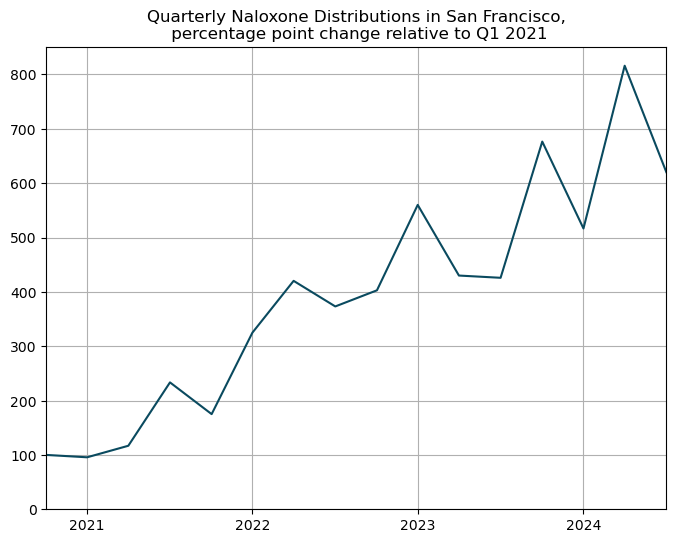

In [354]:
n_baseline = naloxone[naloxone['reporting_period_start_date'] == '2021/01/01'].iloc[0]
n_baseline_count = int(n_baseline['metric_value'])
naloxone_change = [{'start_date': datetime(2021,1,1), 'pct_change': 100}]
for _, row in naloxone.iterrows():
    if row['reporting_period_start_date'] != '2021/01/01':
        n_treatment_counts = int(row['metric_value'])
        n_pct_change = 100 * ((n_treatment_counts)/n_baseline_count)
        n_date = datetime.strptime(row['reporting_period_start_date'], '%Y/%m/%d')
        naloxone_change.append({'start_date':n_date, 'pct_change': n_pct_change})

fig, ax = plt.subplots(figsize=(8, 6))

locator = mdates.MonthLocator(interval=12)
year_month_formatter = mdates.DateFormatter("%Y") # four digits for year, two for month

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(year_month_formatter)

ax.set_ylim(0, 850)
ax.set_xlim(datetime(2021,1,1), datetime(2024,10,1))

ax.grid()

ax.set_title(f'Quarterly Naloxone Distributions in San Francisco,\n percentage point change relative to Q1 2021')

ax.plot(
    [i['start_date'] for i in naloxone_change], [i['pct_change'] for i in naloxone_change],
    color='#0A4A5F',
)
plt.savefig('naloxone.png')

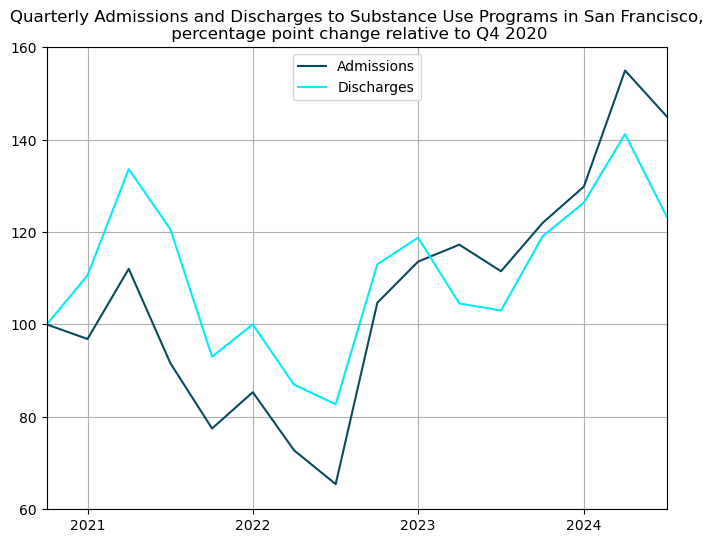

In [352]:
fig, ax = plt.subplots(figsize=(8, 6))

admissions_baseline = int(admissions[admissions['reporting_period_start_date'] == '2021/01/01'].iloc[0]['metric_value'])
ax.plot(
    [datetime.strptime(i[1]['reporting_period_start_date'], '%Y/%m/%d') for i in admissions.iterrows()],
    [100 * i[1]['metric_value'] / admissions_baseline for i in admissions.iterrows()],
    label='Admissions',
    color='#0A4A5F',
)

discharges_baseline = int(discharges[discharges['reporting_period_start_date'] == '2021/01/01'].iloc[0]['metric_value'])
ax.plot(
    [datetime.strptime(i[1]['reporting_period_start_date'], '%Y/%m/%d') for i in discharges.iterrows()],\
    [100 * i[1]['metric_value'] / discharges_baseline for i in discharges.iterrows()],
    label='Discharges',
    color='#00ECF9',
)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(year_month_formatter)

locator = mdates.MonthLocator(interval=12)
year_month_formatter = mdates.DateFormatter("%Y")

ax.set_ylim(60, 160)
ax.set_xlim(datetime(2021,1,1), datetime(2024,10,1))

ax.grid()

ax.legend(loc='upper center')

ax.set_title(f'Quarterly Admissions and Discharges to Substance Use Programs in San Francisco,\n percentage point change relative to Q4 2020')
plt.savefig('treatment.png')